>>>>>> # **Shooting Range Result Predictions**

# **Steps**

- Create and Publish Custom Conda environment
- Run Cell by Cell shooting range predictions
- Convert cell by cell to one .py file
- Deploy .py as Model, to open as REST API

># **1. Conda Env**

# **1.1 Create Conda env**

In [ ]:
Open a command prompt and use:

- odsc conda create -n conda_env -s conda_env -v 1.0

Then, activate the Conda Environment
- conda activate /home/datascience/conda/conda_env

Then, take a note of the yolo conda location
- conda env list

Go to the <NAME_OF_CONDA> folder
- cd /home/datascience/conda/conda_env

# **1.2 Publish Conda to Object Storage**

In [ ]:
#1.st define bucket and namespace where to store
!odsc conda init -b conda_environment_yolov5 -n frqap2zhtzbe -a resource_principal

In [ ]:
#2.nd publish conda env to bucket
!odsc conda publish -s conda_env

---------------

># **2. Step by step code to run!**

# **2.1 Import Libraries**

In [ ]:
## added to the custom conda environment
#!pip install ads
#!pip install opencv-python-headless
#!pip install pandas
#!pip install ocifs
#!pip install matplotlib
#!pip install joblib
#!pip install gradio

In [1]:
#conda: conda_env
import cv2
import os
import math
import pandas as pd
from ocifs import OCIFileSystem
import numpy as np
import matplotlib.pyplot as plt
import glob
import base64
import json
import matplotlib.image as mpimg
import oci
from PIL import Image

## **2.2 Define functions**

In [2]:
# get center of contour
def centroid(contour):
    M = cv2.moments(contour);
    cx = int(round(M['m10']/M['m00']));
    cy = int(round(M['m01']/M['m00']));
    center = (cx, cy);

    return center;

#'center of mass'
def centroid3(contour):
    cx = 0
    cy = 0
    for p in contour:
        cx += p[0][0]
        cy += p[0][1]
    cx = int(cx/len(contour))
    cy = int(cy/len(contour))
    center = (cx, cy);
    return center

# **2.3 Original Example Image**

width:   3024
height:  4032
channel: 3


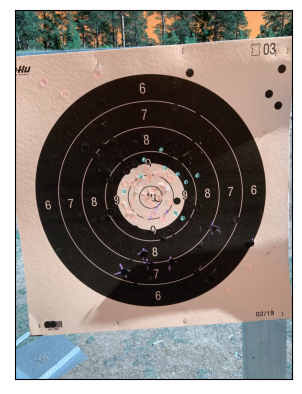

In [10]:
#load original image and show
imagepath="<image_path>"
image = cv2.imread(imagepath,1)
h, w, c = image.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)
plt.imshow(image)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

# **2.3 Cropping image based on pixel values to the larger circle (black and inside white area)**

width:   3024
height:  4032
channel: 3


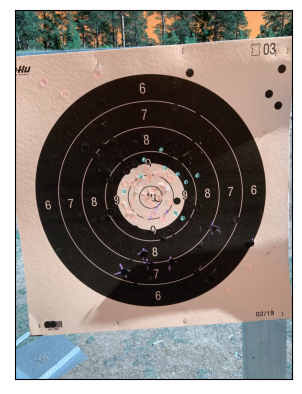

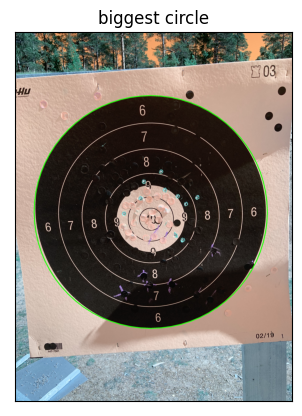

1268
208
704
2536
2536


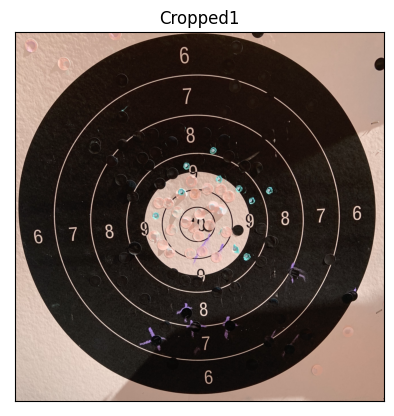

In [11]:
#load image and convert to grayscale + blur slightly
#imagepath=""
#image = cv2.imread(imagepath)
h, w, c = image.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

plt.imshow(image)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray scale
blur = cv2.GaussianBlur(gray_1, (7,7), 0)    #blur image

#review edges. c = 10 (enlarges or decreases the mean values, making the differences larger or not)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,10)

#find the edges and add edges
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    break

# find the biggest contour
biggest_cntr = None;
biggest_area = 0;
for contour in cnts:
    area = cv2.contourArea(contour);
    if area > biggest_area:
        biggest_area = area;
        biggest_cntr = contour;

areas = [cv2.contourArea(c) for c in cnts]
max_index = np.argmax(areas)
biggest_cntr=cnts[max_index]

#method 4
image11=image.copy()
((x2, y2), r2) = cv2.minEnclosingCircle(biggest_cntr)
cv2.circle(image11, (int(x2), int(y2)), int(r2), (36, 255, 12), 10)
plt.title("biggest circle")
plt.imshow(image11)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

big_radius=r2
center=(x2,y2)

r2=int(r2)
rectx= int(x2 - r2)
recty= int(y2 - r2)
recth= int(r2 + r2)
rectw= int(r2 + r2)
print(r2)
print(rectx)
print(recty)
print(rectw)
print(recth)

image3=image.copy()
cropped_image = image3[recty-10:recty+rectw+50, rectx-10:rectx+rectw+50]

#show cropped image
plt.title("Cropped1")
plt.imshow(cropped_image)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [12]:
#save cropped image
#c_array = np.asarray(cropped_image)
im = Image.fromarray(cropped_image)
im.save("<save_directory")

# **2.4 Detect Yellow target hole areas**

width:   2596
height:  2596
channel: 3


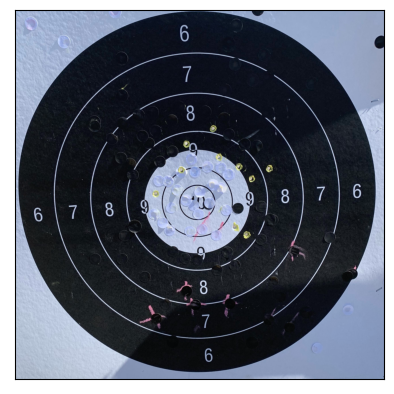

big radius2:  76.47110613836779


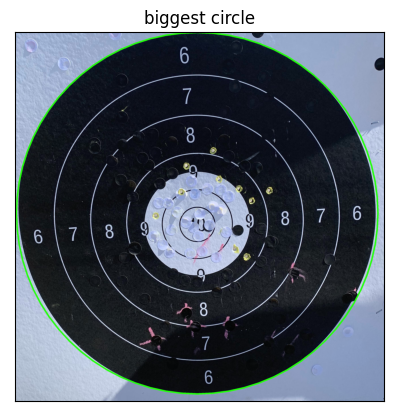

In [13]:
# read image in BGR

img = cv2.imread("<image_path>")
#img=np.asarray(img)
h, w, c = img.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

plt.imshow(img)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

#############
image=img.copy()
gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray scale
blur = cv2.GaussianBlur(gray_1, (7,7), 0)    #blur image

#review edges. c = 10 (enlarges or decreases the mean values, making the differences larger or not)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,10)


#find the edges and add edges
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
#for c in cnts:
#    x,y,w,h = cv2.boundingRect(c)
#    cropped_image = image[y:y+h, x:x+w]
#    break
#print(x)
#print(y)
#print(w)
#print(h)

# find the biggest contour
biggest_cntr = None;
biggest_area = 0;
for contour in cnts:
    area = cv2.contourArea(contour);
    if area > biggest_area:
        biggest_area = area;
        biggest_cntr = contour;

areas = [cv2.contourArea(c) for c in cnts]
max_index = np.argmax(areas)
biggest_cntr=cnts[max_index]
# find biggest radius
big_radius2 = math.sqrt(biggest_area / math.pi);
print("big radius2: ", big_radius2)
center2=centroid3(biggest_cntr)


#method 2
image11=image.copy()
((x2, y2), r2) = cv2.minEnclosingCircle(biggest_cntr)
cv2.circle(image11, (int(x2), int(y2)), int(r2), (36, 255, 12), 10)
plt.title("biggest circle")
plt.imshow(image11)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

big_radius=r2
center=(x2,y2)

##############

# convert to LAB space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# store the a-channel
a_channel = lab[:,:,1]

# Automate threshold using Otsu method
th = cv2.threshold(a_channel,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

# Mask the result with the original image
masked = cv2.bitwise_and(img, img, mask = th)

# **2.5 Show Masked Image with Bullet Holes isolated**

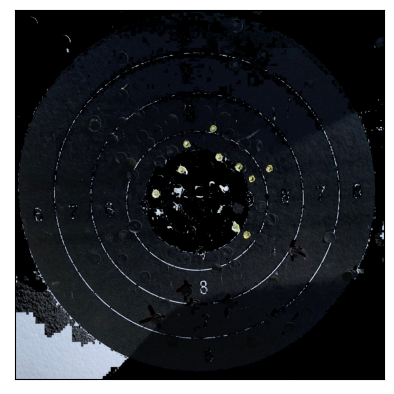

In [14]:
plt.imshow(masked)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [15]:
#save image
im = Image.fromarray(masked)
im.save("<save_image")

# **2.6 Detect yellow bullet holes on masked image**

In [16]:
#read masked image
masked_image = cv2.imread("<image_directory>")

# convert to hsv colorspace
hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

# lower bound and upper bound for Yellow color
lower_bound = np.array([20,30,40])      #23,41,133  #5,0,10 #20,30,40
upper_bound = np.array([40, 150, 255])

# find the colors within the boundaries
mask = cv2.inRange(hsv, lower_bound, upper_bound)

In [17]:
#define kernel size  
kernel = np.ones((7,7),np.uint8)

# Remove unnecessary noise from mask
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

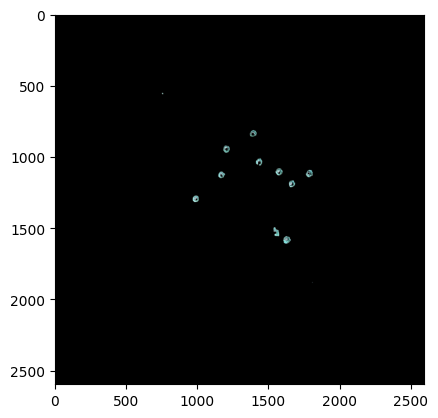

In [18]:
# Segment only the detected region
segmented_img = cv2.bitwise_and(masked_image, masked_image, mask=mask)
plt.imshow(segmented_img)
plt.show()

12


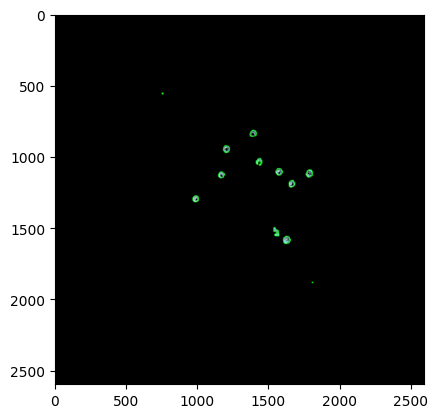

In [19]:
# Find contours from the mask
contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#output = cv2.drawContours(segmented_img.copy(), contours, -1, (0, 255, 0), 3)
output = cv2.drawContours(segmented_img, contours, -1, (0, 255, 0), 3)

# Showing the output
print(len(contours))
plt.imshow(output)
plt.show()

In [20]:
#save image
im = Image.fromarray(output)
im.save("<save_image>")

----------------------

>> # **TEST 1 - CONTOURS**

------------------

# **2.7 Adding Contours to Image and getting distance from center!**

1268.87841796875
slices 253.77568359375
dist :  462.8896896831382
okk  9
ok 9
dist :  371.83183221156764
okk  9
ok 9
dist :  292.571824565859
okk  9
ok 9
dist :  391.92962334927176
okk  9
ok 9
dist :  187.71323245103858
okk  10
ok 10
dist :  530.5907688922811
okk  8
ok 8
dist :  339.5777063111561
okk  9
ok 9
dist :  287.70176186425374
okk  9
ok 9
dist :  340.23864782120506
okk  9
ok 9
dist :  454.409764639491
okk  9
ok 9


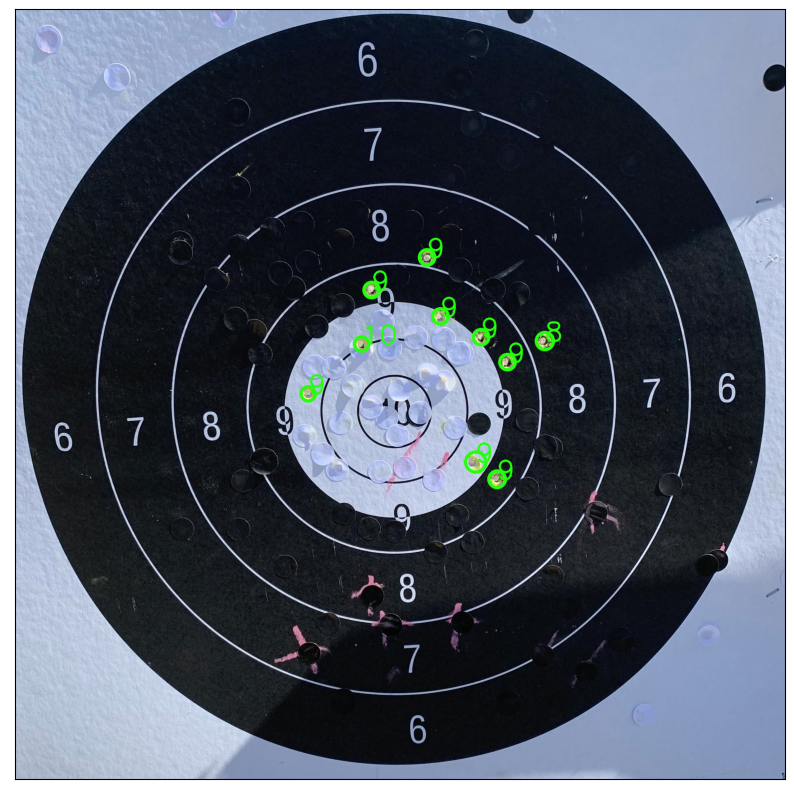

In [21]:
aa2 = img.copy()

# calculate approximate size of each ring
# (with foreknowledge that there are 9 + bullseye)
print(big_radius)
slices = big_radius/5;
print("slices", slices)
# calculate scores
scores = [];
#print("holes lenths : ", len(holes))
for cnt in contours:
    (ax,ay)= centroid(cnt)
    ((xt2, yt2), rt2) = cv2.minEnclosingCircle(cnt)
    if rt2>10:
        aa2=cv2.circle(aa2, (int(xt2), int(yt2)), int(rt2), (36, 255, 12), 10)

       # get distance from center
        dx = ax - center[0];  #xt2
        dy = ay - center[1];  #yt2
        dist = math.sqrt(dx*dx + dy*dy)
        print("dist : ", dist)
    

        print("okk ", 10 - int(dist / slices))
        score = 10 - int(dist /slices)  #10-int(dist / slices)
        print("ok", score)   
        
        # draw the scores
        font = cv2.FONT_HERSHEY_SIMPLEX ;
        tup = (int(xt2), int(yt2))
        cv2.putText(aa2, str(score), tup, font, 3, (36, 255, 12), 5, cv2.LINE_AA); 

#        cv2.cvtColor(aa2, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other

plt.figure(figsize = (30,10)) 
plt.imshow(aa2)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

>> # **TEST 2 - CIRCLES**

detected circles : [[[1781.  1125.    22.8]
  [1665.  1191.    22. ]
  [1571.  1109.    20.8]
  [1391.   837.    25.2]
  [ 987.  1299.    23.2]
  [1203.   947.    20. ]
  [1625.  1587.    18.2]
  [1427.  1039.    19.8]
  [1175.  1129.    19.4]
  [1553.  1529.    18.4]]]
detected circles shape: (1, 10, 3)


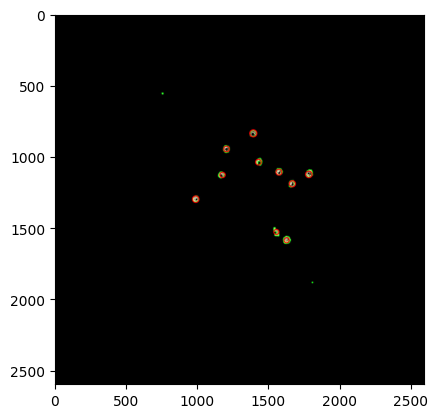

In [22]:
# Convert to grayscale.
isolated_image = cv2.imread("<image_directory>")

gray_2 = cv2.cvtColor(isolated_image, cv2.COLOR_BGR2GRAY)

# # Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray_2, (3, 3))

# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp = 2, minDist = 50, param1 = 40, param2 = 40, minRadius = 15, maxRadius = 35)
#dp = 2, minDist = 50, param1 = 40, param2 = 40, minRadius = 15, maxRadius = 35) original bob
#dp = 2, minDist = 50, param1 = 10, param2 = 30, minRadius = 10, maxRadius = 25)
#dp = 2, minDist = 50, param1 = 10, param2 = 30, minRadius = 15, maxRadius = 25)

print("detected circles :", detected_circles)
print("detected circles shape:", detected_circles.shape)

# Draw circles that are detected.
if detected_circles is not None:

    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        # Draw the circumference of the circle.
        cv2.circle(isolated_image, (a, b), r, (255, 0, 0), 5)

plt.imshow(isolated_image) #isolated_image)
plt.show()

In [23]:
# Draw circles that are detected.
temp_image=img.copy()
plt.imshow(temp_image)
#plt.show()
circles=[]
if detected_circles is not None:

    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        # Draw the circumference of the circle.
        circles.append((a,b))
        cv2.circle(temp_image, (a, b), r, (0, 0, 255), 6)


#print(detected_circles)
#plt.figure(figsize = (30,10))
#plt.imshow(temp_image)
#plt.show()

1268.87841796875
slices 253.77568359375
detected_circleslenths :  10
502.004638671875
-153.6429443359375
dist :  524.9902966648963
ok :  8
386.004638671875
-87.6429443359375
dist :  395.8293404588359
ok :  9
292.004638671875
-169.6429443359375
dist :  337.7061408515668
ok :  9
112.004638671875
-441.6429443359375
dist :  455.62432920744396
ok :  9
-291.995361328125
20.3570556640625
dist :  292.7041180995785
ok :  9
-75.995361328125
-331.6429443359375
dist :  340.23864782120506
ok :  9
346.004638671875
308.3570556640625
dist :  463.46875165459056
ok :  9
148.004638671875
-239.6429443359375
dist :  281.66312118981693
ok :  9
-103.995361328125
-149.6429443359375
dist :  182.23074923649895
ok :  10
274.004638671875
250.3570556640625
dist :  371.1565671444913
ok :  9


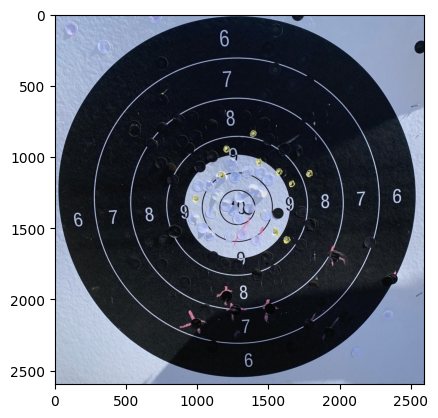

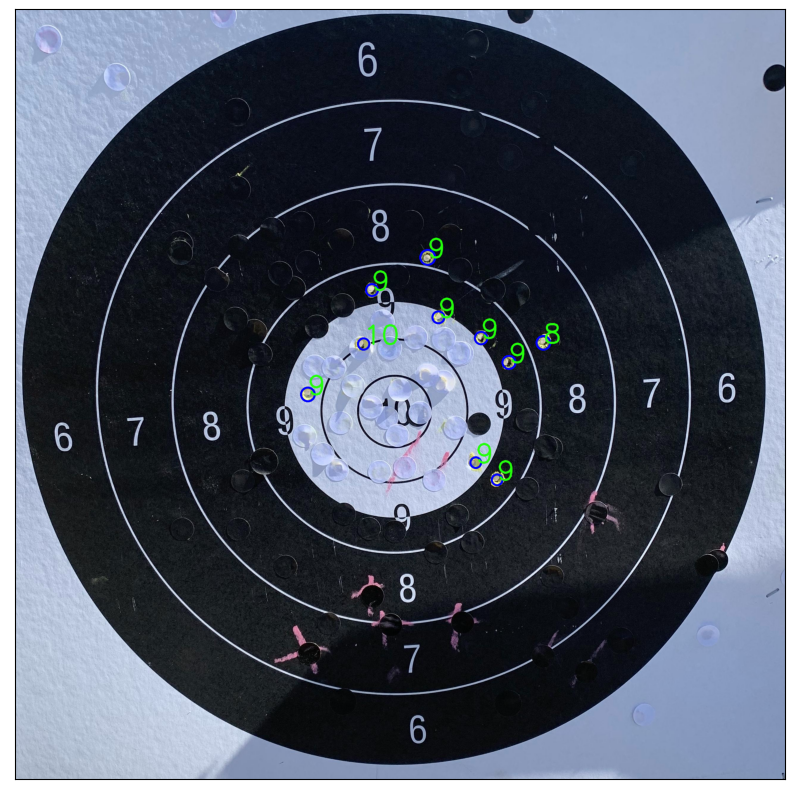

In [24]:
temp_image4=temp_image.copy()

print(big_radius)
#print(little_radius)
#print(remaining_radius)
slices = big_radius / 5

print("slices", slices)
# calculate scores
scores = [];

print("detected_circleslenths : ", len(circles))
for pt in circles:
      
    # get distance from center
    dx = pt[0] - center[0]
    dy = pt[1] - center[1]
    print(dx)
    print(dy)
    dist = math.sqrt(dx*dx + dy*dy) 
    
    print("dist : ", dist)

    scoreval= 10- int(dist / slices)
    print("ok : ", scoreval)
    scores.append(scoreval)

#print("scores : ", scores)
        
# draw the scores
    font = cv2.FONT_HERSHEY_SIMPLEX 
#    for a in range(len(detected_circles)):
    tup = (pt[0],pt[1])
#    marked = cv2.putText(marked, str(scores[a]), tup, font, 3, (0,0,155), 2, cv2.LINE_AA);
    cv2.putText(temp_image4, str(scoreval), tup, font, 3, (36, 255, 12), 5, cv2.LINE_AA)

plt.figure(figsize = (30,10)) 
plt.imshow(temp_image4)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [25]:
scores

[8, 9, 9, 9, 9, 9, 9, 9, 10, 9]

----------------

--------------

> # **4. Image in a small User Interface!**

# **4.1 Define functions**

In [3]:
    # get center of contour
    def centroid(contour):
        M = cv2.moments(contour);
        cx = int(round(M['m10']/M['m00']));
        cy = int(round(M['m01']/M['m00']));
        center = (cx, cy);

        return center;

    #'center of mass'
    def centroid3(contour):
        cx = 0
        cy = 0
        for p in contour:
            cx += p[0][0]
            cy += p[0][1]
        cx = int(cx/len(contour))
        cy = int(cy/len(contour))
        center = (cx, cy);
        return center

# **4.2 Run Gradio App. Below Function returns image as NP array**

In [9]:
import numpy as np
import gradio as gr

def image_processing_np(input_img):
    image = cv2.imread(input_img,1)
    ## add afterads: image.reshape(2500,2500) check
    h, w, c = image.shape

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    #load image and convert to grayscale + blur slightly
    gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray scale
    blur = cv2.GaussianBlur(gray_1, (7,7), 0)    #blur image

    #review edges. c = 10 (enlarges or decreases the mean values, making the differences larger or not)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,10)

    #find the edges and add edges
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        break

    # find the biggest contour
    biggest_cntr = None;
    biggest_area = 0;
    for contour in cnts:
        area = cv2.contourArea(contour);
        if area > biggest_area:
            biggest_area = area;
            biggest_cntr = contour;

    areas = [cv2.contourArea(c) for c in cnts]
    max_index = np.argmax(areas)
    biggest_cntr=cnts[max_index]

    #method 4
    image11=image.copy()
    ((x2, y2), r2) = cv2.minEnclosingCircle(biggest_cntr)
    cv2.circle(image11, (int(x2), int(y2)), int(r2), (36, 255, 12), 10)

    big_radius=r2
    center=(x2,y2)

    r2=int(r2)
    rectx= int(x2 - r2)
    recty= int(y2 - r2)
    recth= int(r2 + r2)
    rectw= int(r2 + r2)

    image3=image.copy()
    cropped_image = image3[recty-10:recty+rectw+50, rectx-10:rectx+rectw+50]


    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    #start with cropped_image
    img = Image.fromarray(cropped_image)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # read image in BGR

    img=np.asarray(img)
    h, w, c = img.shape


    #############
    image=img.copy()
    gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray scale
    blur = cv2.GaussianBlur(gray_1, (7,7), 0)    #blur image

    #review edges. c = 10 (enlarges or decreases the mean values, making the differences larger or not)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,10)


    #find the edges and add edges
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    # find the biggest contour
    biggest_cntr = None;
    biggest_area = 0;
    for contour in cnts:
        area = cv2.contourArea(contour);
        if area > biggest_area:
            biggest_area = area;
            biggest_cntr = contour;

    areas = [cv2.contourArea(c) for c in cnts]
    max_index = np.argmax(areas)
    biggest_cntr=cnts[max_index]
    # find biggest radius
    big_radius2 = math.sqrt(biggest_area / math.pi);
    #print("big radius2: ", big_radius2)
    center2=centroid3(biggest_cntr)


    #method 2
    image11=image.copy()
    ((x2, y2), r2) = cv2.minEnclosingCircle(biggest_cntr)
    cv2.circle(image11, (int(x2), int(y2)), int(r2), (36, 255, 12), 10)


    big_radius=r2
    center=(x2,y2)

    ##############

    # convert to LAB space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # store the a-channel
    a_channel = lab[:,:,1]

    # Automate threshold using Otsu method
    th = cv2.threshold(a_channel,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    # Mask the result with the original image
    masked = cv2.bitwise_and(img, img, mask = th)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    #save image
    im = Image.fromarray(masked)
    masked_image=np.asarray(im)                   ##added on original code

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # convert to hsv colorspace
    hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

    # lower bound and upper bound for Yellow color
    lower_bound = np.array([20,30,40])      #23,41,133  #5,0,10 #20,30,40
    upper_bound = np.array([40, 150, 255])

    # find the colors within the boundaries
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    #define kernel size  
    kernel = np.ones((7,7),np.uint8)

    # Remove unnecessary noise from mask
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # Segment only the detected region
    segmented_img = cv2.bitwise_and(masked_image, masked_image, mask=mask)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # Find contours from the mask
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #output = cv2.drawContours(segmented_img.copy(), contours, -1, (0, 255, 0), 3)
    output = cv2.drawContours(segmented_img, contours, -1, (0, 255, 0), 3)

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    im_output = Image.fromarray(output)
    isolated_image=np.asarray(im_output)                   ##added on original code

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # Convert to grayscale.
    gray_2 = cv2.cvtColor(isolated_image, cv2.COLOR_BGR2GRAY)

    # # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray_2, (3, 3))

    # Apply Hough transform on the blurred image.
    detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp = 2, minDist = 50, param1 = 40, param2 = 40, minRadius = 15, maxRadius = 35)

    # Draw circles that are detected.
    if detected_circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            # Draw the circumference of the circle.
            cv2.circle(isolated_image, (a, b), r, (255, 0, 0), 5)

    # plt.imshow(isolated_image) #isolated_image)
    # plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    # Draw circles that are detected.
    temp_image=img.copy()
    #plt.imshow(temp_image)
    #plt.show()
    circles=[]
    if detected_circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            # Draw the circumference of the circle.
            circles.append((a,b))
            cv2.circle(temp_image, (a, b), r, (0, 0, 255), 6)

    ###################### METHOD 2 - CIRCLES ###################################
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    temp_image4=temp_image.copy()

    slices = big_radius / 5

    # calculate scores
    scores = [];

    # print("detected_circleslenths : ", len(circles))
    for pt in circles:

        # get distance from center
        dx = pt[0] - center[0]
        dy = pt[1] - center[1]
    #     print(dx)
    #     print(dy)
        dist = math.sqrt(dx*dx + dy*dy) 

    #     print("dist : ", dist)

        scoreval= 10- int(dist / slices)
    #     print("ok : ", scoreval)
        scores.append(scoreval)

    #print("scores : ", scores)

    # draw the scores
        font = cv2.FONT_HERSHEY_SIMPLEX 
    #    for a in range(len(detected_circles)):
        tup = (pt[0],pt[1])
    #    marked = cv2.putText(marked, str(scores[a]), tup, font, 3, (0,0,155), 2, cv2.LINE_AA);
        cv2.putText(temp_image4, str(scoreval), tup, font, 3, (36, 255, 12), 5, cv2.LINE_AA)

    im_output = Image.fromarray(temp_image4)
    image_as_np = np.asarray(im_output)  
    return image_as_np

######
#####
## launch Gradio

demo = gr.Interface(image_processing_np, gr.Image(type="filepath"), "image")
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7865/
Running on public URL: https://30257.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f9eac382650>,
 'http://127.0.0.1:7865/',
 'https://30257.gradio.app')

-----------

------------------------